# Pre-requisites

In [1]:
!git clone https://github.com/TezBytes/music-recommender/

Cloning into 'music-recommender'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
Receiving objects: 100% (13/13), 6.75 KiB | 6.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.
remote: Total 13 (delta 1), reused 7 (delta 0), pack-reused 0 (from 0)


In [5]:
cd music-recommender/

/content/music-recommender


In [6]:
!git fetch origin
!git checkout feat/eda-and-baseline-siimilarity

Branch 'feat/eda-and-baseline-siimilarity' set up to track remote branch 'feat/eda-and-baseline-siimilarity' from 'origin'.
Switched to a new branch 'feat/eda-and-baseline-siimilarity'


In [9]:
!pip install kagglehub[pandas-datasets]

# Load dataset

In [10]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "maharshipandya/-spotify-tracks-dataset",
  file_path,
)

print("First 5 records:", df.head())

<ipython-input-10-9ef33fd9699e>:7: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210

In [11]:
print(df.shape)

(114000, 21)


In [12]:
print(df.head)

<bound method NDFrame.head of         Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1      

# Drop Duplicates on track_id

In [13]:
df.drop_duplicates(subset=['track_id'], inplace=True)

In [14]:
print(f"After dropping duplicates: {df.shape}")

After dropping duplicates: (89741, 21)


# Remove Rows with Missing Elements

In [15]:
req_cols = ["track_name","danceability", "energy", "track_id" ]
df.dropna(subset=req_cols, inplace=True)

In [16]:
print(f"After dropping missing values: {df.shape}")

After dropping missing values: (89740, 21)


# Convert Data Types

In [17]:
df["explicit"] = df["explicit"].astype(bool)
df["duration_sec"] = df["duration_ms"] / 1000
df["duration_sec"] = df["duration_sec"].astype(int)

# Normalize Numerical Features

In [18]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ["danceability", "energy", "duration_sec"]
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Save Cleaned Data

In [19]:
import os

if not os.path.exists("data"):
    os.makedirs("data")
    print("Directory 'data' created successfully.")
else:
    print("Directory 'data' already exists.")

Directory 'data' created successfully.


In [20]:
df.to_csv("data/enriched_data.csv", index=False)

# Write to utils.py

In [21]:
import os

# Make sure the folder exists
os.makedirs("scripts", exist_ok=True)

# Create empty utils.py
with open("scripts/utils.py", "w") as f:
    f.write("")  # just creates the file

In [22]:
utils_code = """
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def load_dataset(path):
    df = pd.read_csv(path)
    return df

def drop_duplicates(df, subset_col="track_id"):
    return df.drop_duplicates(subset=subset_col)

def clean_missing_values(df, required_cols):
    return df.dropna(subset=required_cols)

def convert_types(df):
    df["explicit"] = df["explicit"].astype(bool)
    df["duration_sec"] = df["duration_ms"] / 1000
    return df.drop(columns=["duration_ms"])

def normalize_features(df, cols):
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df
"""

with open("scripts/utils.py", "w") as f:
    f.write(utils_code)

# Use in notebook

In [23]:
import sys
sys.path.append("scripts")

import utils

df = utils.load_dataset("data/enriched_data.csv")

In [24]:
print(df.shape)

(89740, 22)


# Analyze distribution of key features (valence, energy, tempo, etc.)



1.   Numeric Feature Distributions



In [26]:
numeric_features = [
    'popularity', 'duration_ms', 'danceability', 'energy',
    'valence', 'tempo', 'speechiness', 'acousticness',
    'instrumentalness'
]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

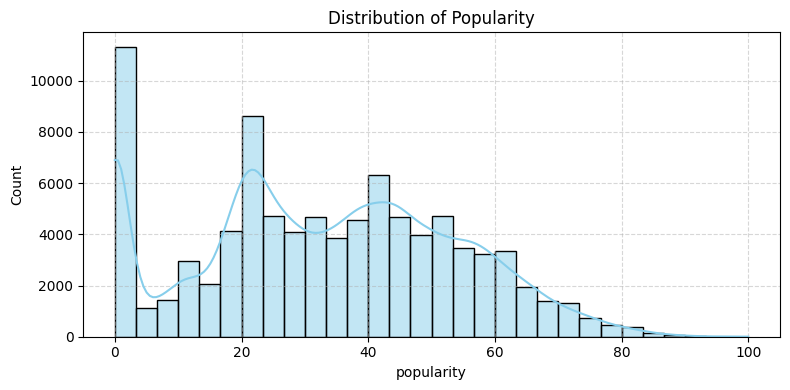

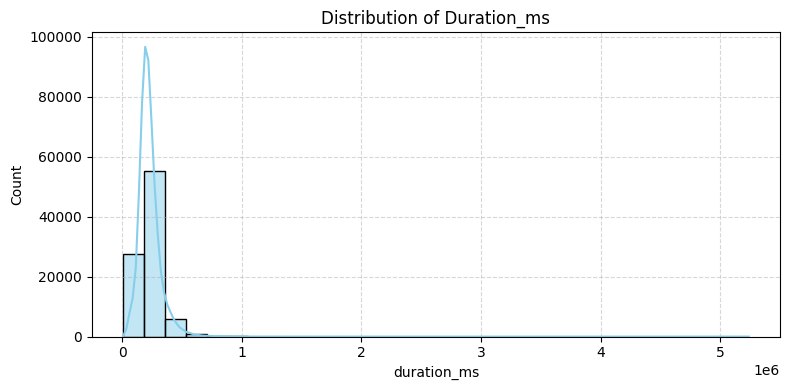

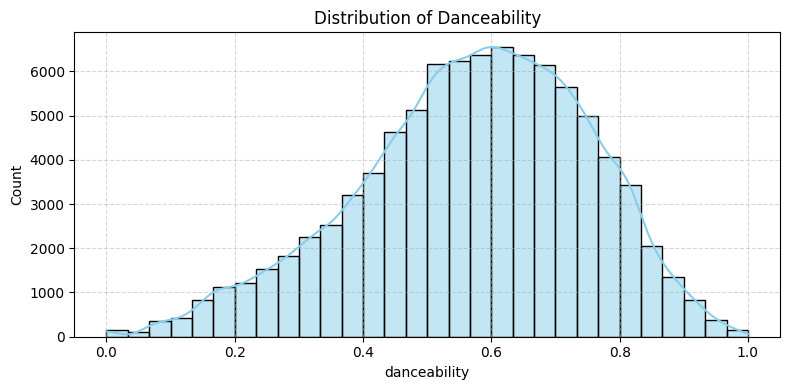

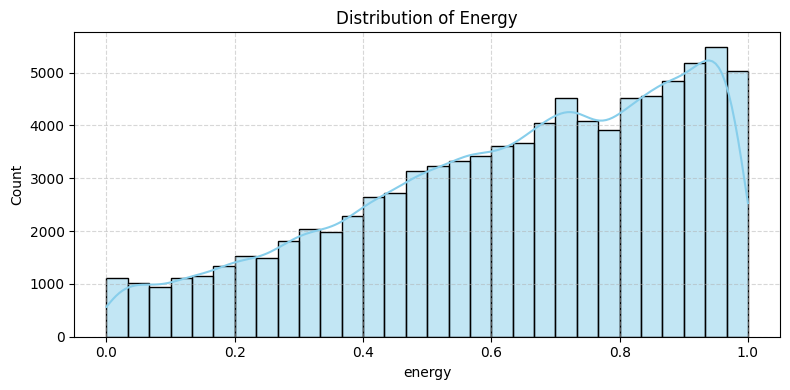

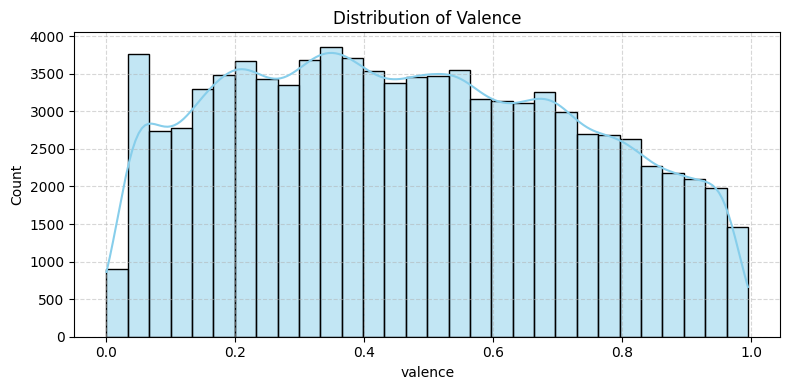

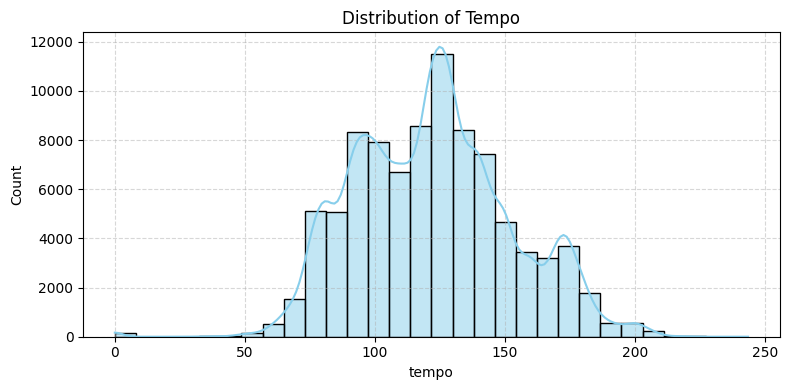

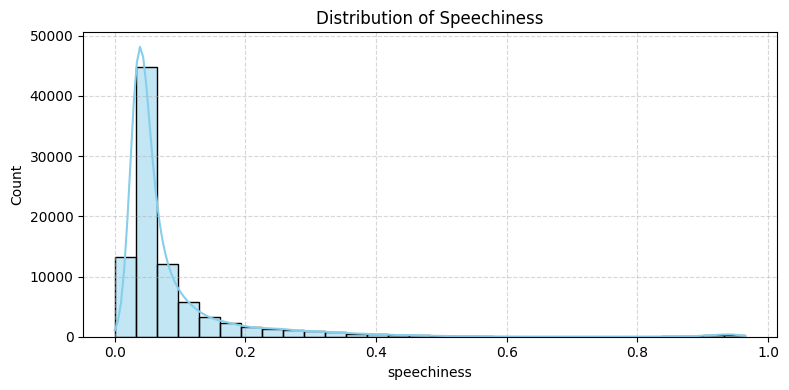

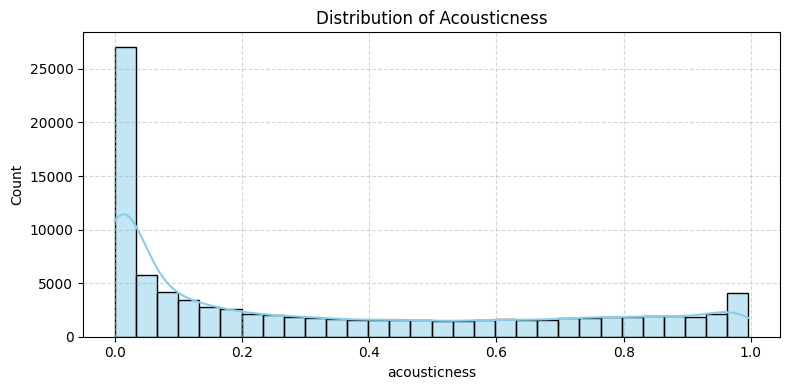

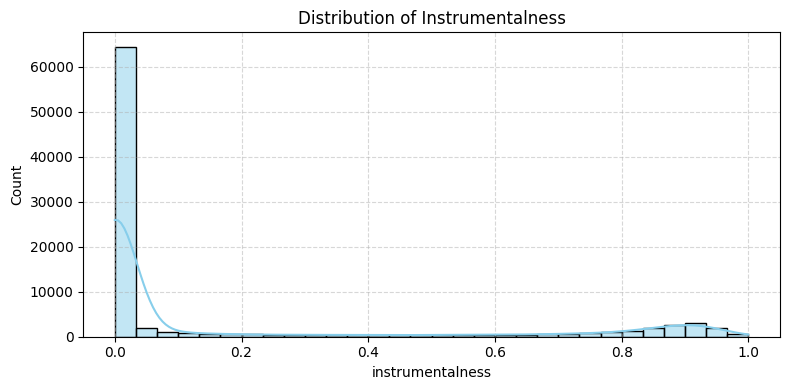

In [28]:
for f in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[f], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {f.capitalize()}')
    plt.xlabel(f)
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()




2.   Categorical Features (explicit, track_genre)



<ipython-input-29-1694be821a8f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='explicit', data=df, palette='pastel')


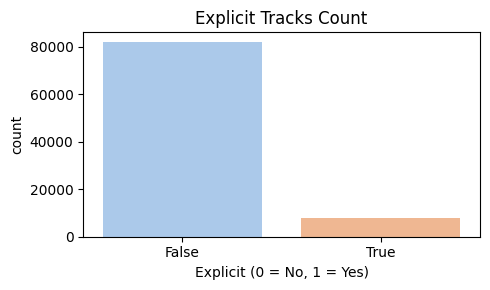

In [29]:
# Explicit
plt.figure(figsize=(5, 3))
sns.countplot(x='explicit', data=df, palette='pastel')
plt.title('Explicit Tracks Count')
plt.xlabel('Explicit (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

<ipython-input-30-b9d9e40c7341>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='muted')


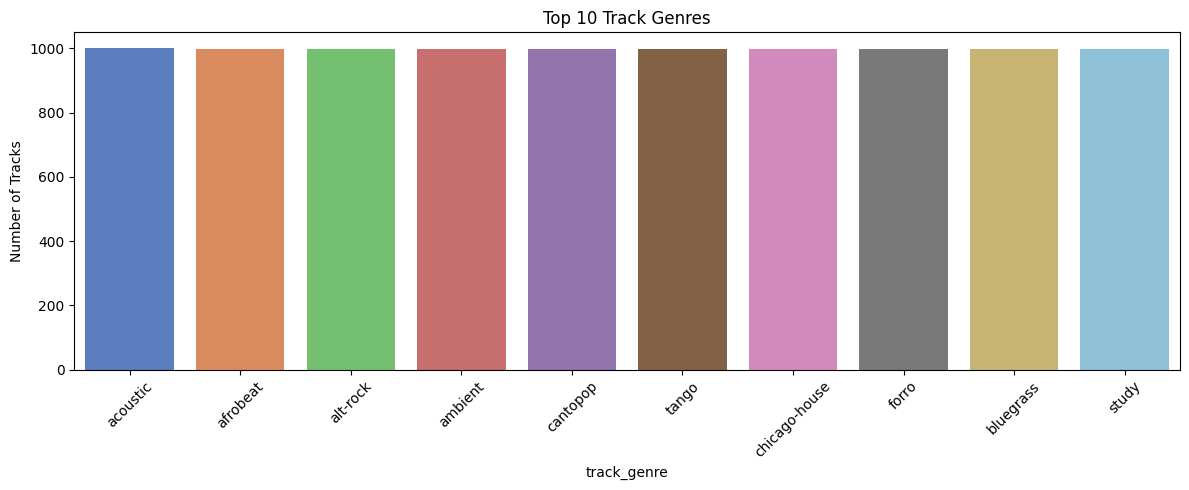

In [30]:
# Track Genre (top 10)
plt.figure(figsize=(12, 5))
top_genres = df['track_genre'].value_counts().nlargest(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette='muted')
plt.title('Top 10 Track Genres')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. Distribution Across Genres (Boxplots)

In [31]:
top_genres = df['track_genre'].value_counts().nlargest(5).index
subset = df[df['track_genre'].isin(top_genres)]

<ipython-input-32-b0923e0d8c28>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='track_genre', y=f, palette='Set2')


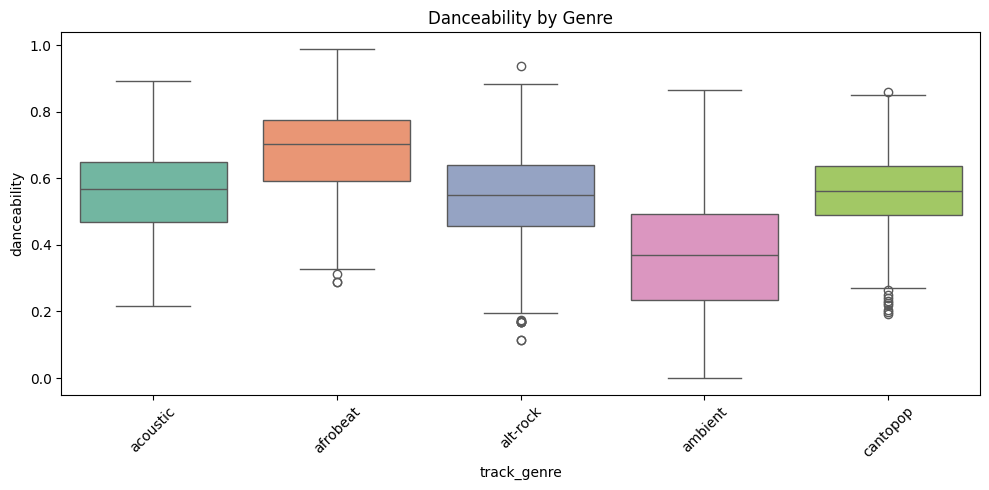

<ipython-input-32-b0923e0d8c28>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='track_genre', y=f, palette='Set2')


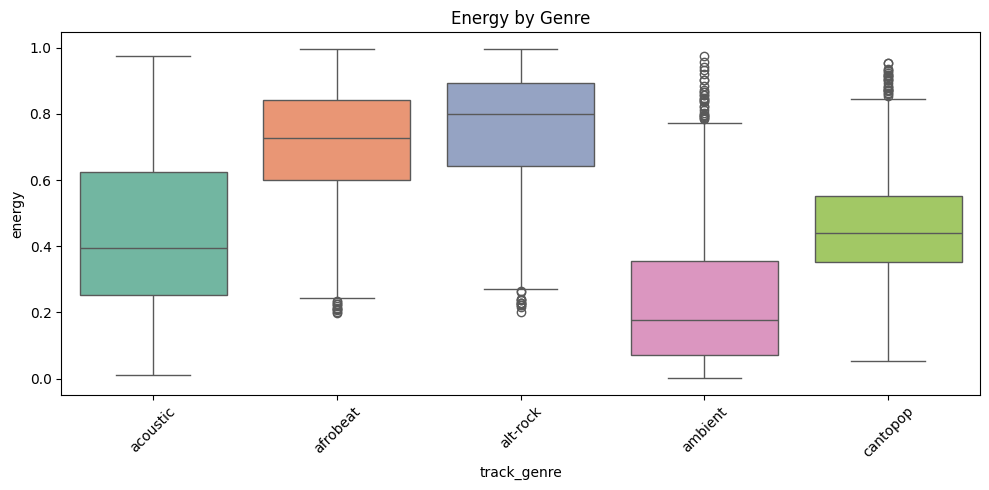

<ipython-input-32-b0923e0d8c28>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='track_genre', y=f, palette='Set2')


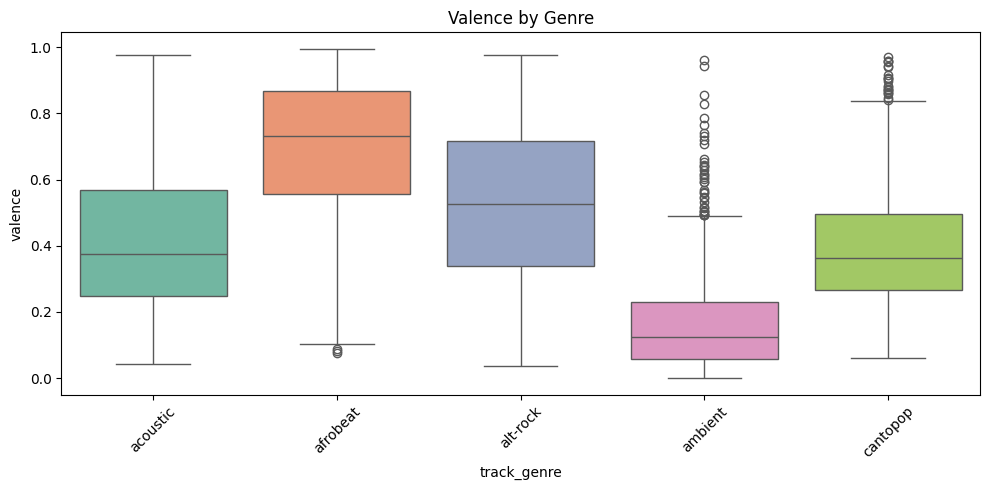

In [32]:
for f in ['danceability', 'energy', 'valence']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=subset, x='track_genre', y=f, palette='Set2')
    plt.title(f'{f.capitalize()} by Genre')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

4. Correlation Heatmap of Audio Features

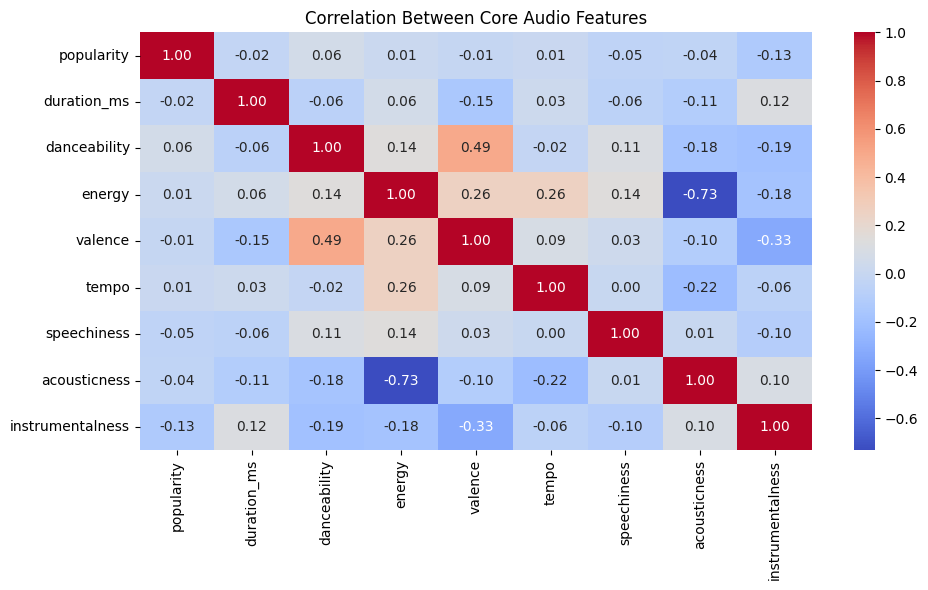

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Between Core Audio Features")
plt.tight_layout()
plt.show()

# Perform PCA or TSNE to visualize clusters

1. Select and Normalize Numeric Features

In [34]:
features = [
    'danceability', 'energy', 'valence', 'tempo',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'loudness', 'duration_ms'
]

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
X = df[features].dropna()

In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2. PCA Visualization

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [40]:
df['pca-1'] = X_pca[:, 0]
df['pca-2'] = X_pca[:, 1]

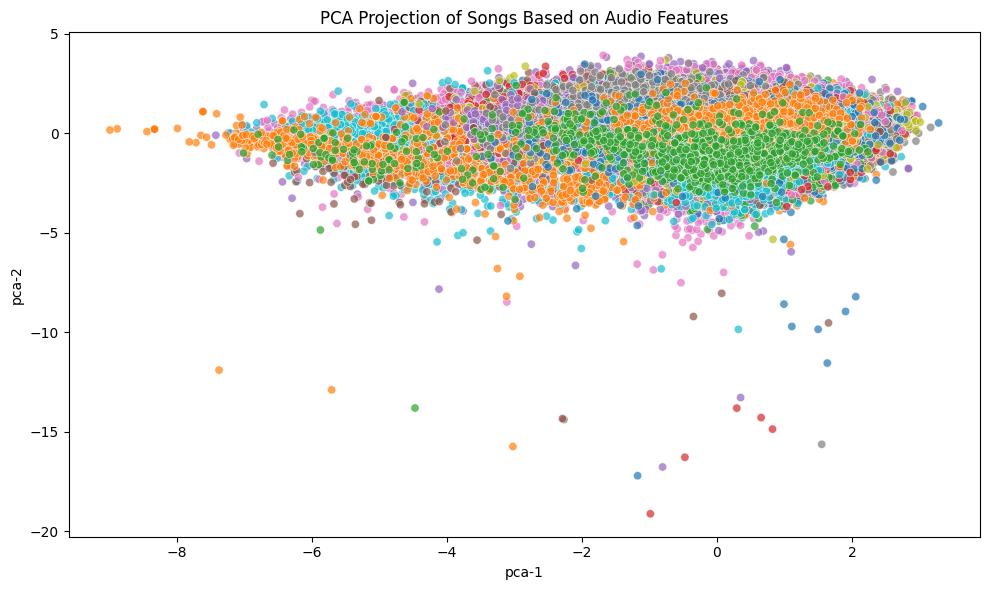

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca-1', y='pca-2',
    hue=df['track_genre'],  # Or any other label
    data=df, palette='tab10', legend=False, alpha=0.7
)
plt.title("PCA Projection of Songs Based on Audio Features")
plt.tight_layout()
plt.show()

3. UMAP Visualization

In [44]:
!pip install umap-learn

In [45]:
import umap

In [46]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [48]:
df['umap-1'] = X_umap[:, 0]
df['umap-2'] = X_umap[:, 1]

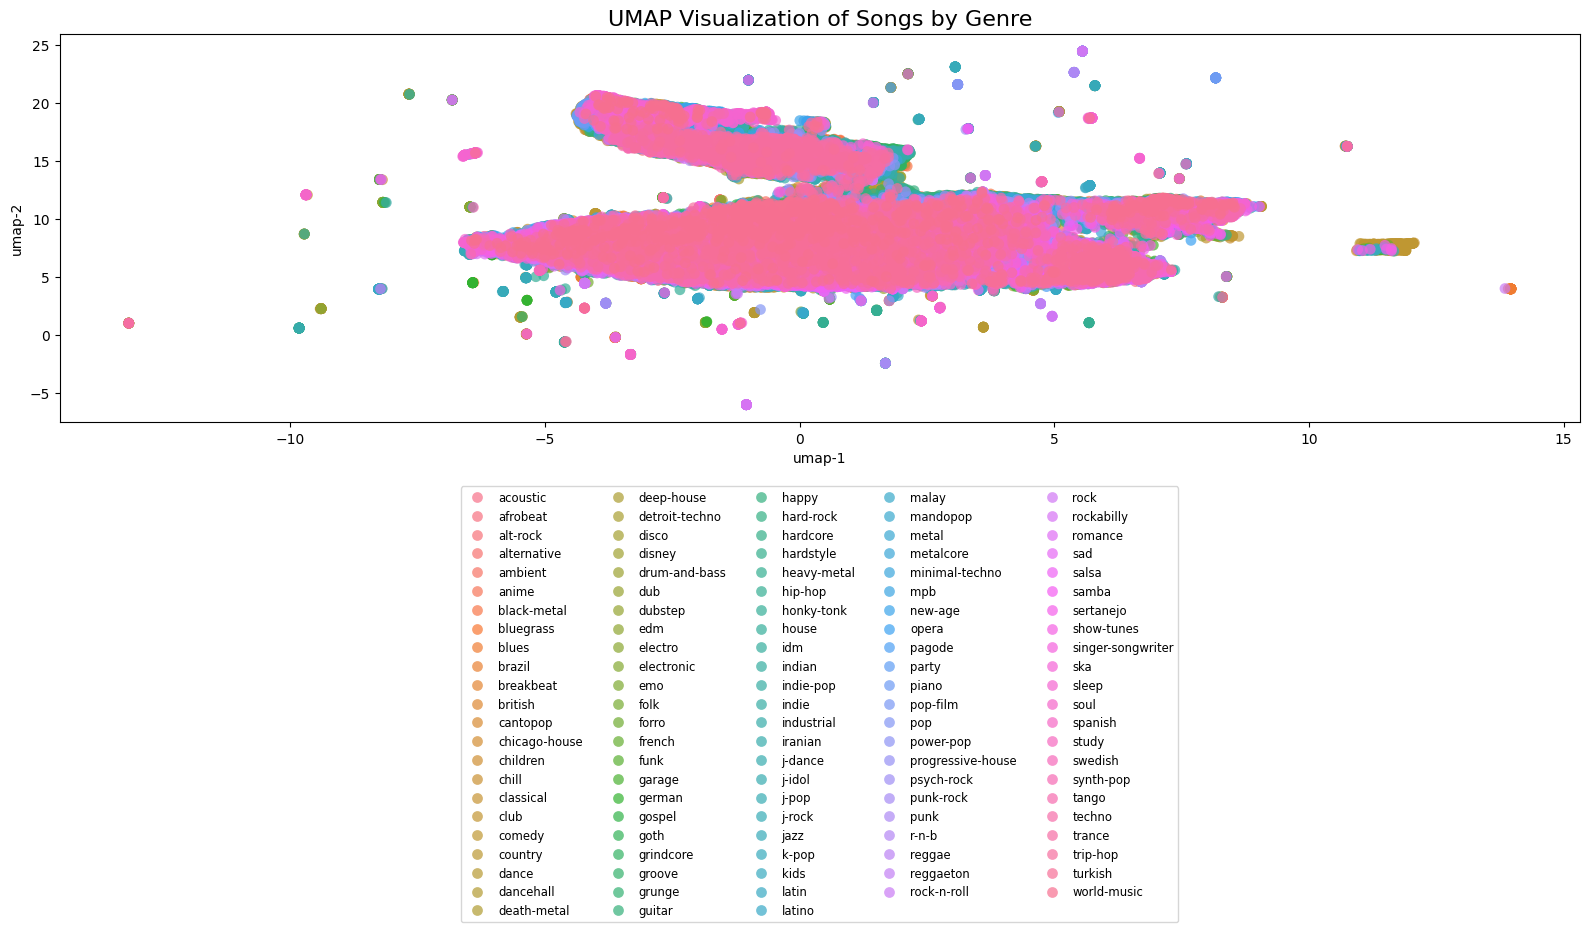

In [58]:
plt.figure(figsize=(16, 10))

sns.scatterplot(
    x='umap-1',
    y='umap-2',
    hue=df['track_genre'],
    data=df,
    alpha=0.7,
    s=60,
    edgecolor='none'
)

plt.title("UMAP Visualization of Songs by Genre", fontsize=16)

# Legend below the plot
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,  # Number of columns in the legend
    fontsize='small'
)

plt.tight_layout()
plt.show()

# Build a function to recommend songs based on cosine similarity using key features